This anlysis is taken from:  
http://www.real-statistics.com/regression/hypothesis-testing-significance-regression-line-slope/comparing-slopes-two-independent-samples/

### Motivation
This notebook is being created to get some practice with comparing the significance in the difference between the slopes of two regression lines.  The reference above was done in Excel.

### Problem Statement and Definitions
Start with two sets of data: logevity vs. number of cigarettes per day for two populations, one for men and one for women.  Does increase smoking decrease longevity in men an women the same amount?

Let's start with a quick plot.

In [7]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline

# make analysis repeatable by referencing data available online
try:
    men_data = pd.read_csv('https://raw.githubusercontent.com/MichaelSzczepaniak/SlopeInference/master/men_cig_life_exp.csv')
    women_data = pd.read_csv('https://raw.githubusercontent.com/MichaelSzczepaniak/SlopeInference/master/women_cig_life_exp.csv')
except:
    men_data = pd.read_csv('https://www.dropbox.com/s/te8narzivsj5c8f/men_cig_life_exp.csv?dl=1')
    women_data = pd.read_csv('https://www.dropbox.com/s/ju2g6eetfcomhsc/women_cig_life_exp.csv?dl=1')

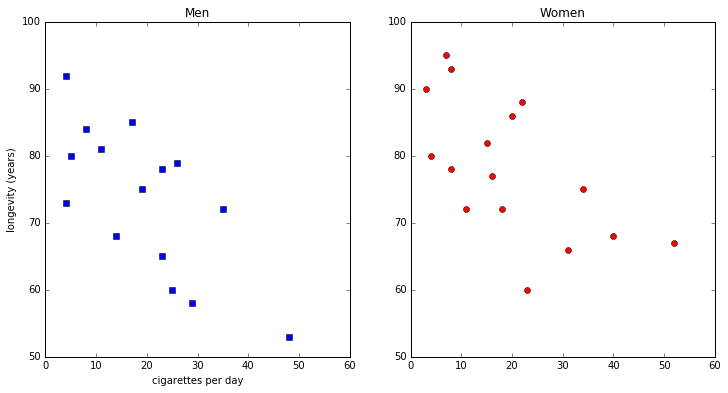

In [8]:
fig = plt.figure(1, figsize=(12, 6))

ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan=1, sharey=ax1)

ax1.set_title('Men')
ax2.set_title('Women')

ax1.set_xlim(0, 60); ax2.set_xlim(0, 60)
ax1.set_ylim(50, 100); ax2.set_ylim(50, 100)
ax1.set_ylabel('longevity (years)')
ax1.set_xlabel('cigarettes per day')

ax1.plot(men_data['cig_x'], men_data['life_exp'], 'bs')
ax2.plot(women_data['cig_x'], women_data['life_exp'], 'ro')

Looks like it trends down with increasing number of cigarettes per day. Let's add some regression lines to see this more clearly.

In [9]:
def trainLinear(X, T):
    """ Returns a (D+1, k) column vector of weights for the linear regression of
    T vs. X.  Parameters:
    X is a n by D matrix of features, n = number of samples, D = dimensions (feature count)
    T is a n by k matrix of targets, n = number of samples, k = number of targets
    """
    X1 = np.hstack((np.ones((len(X), 1)), X))  # N x 1 vector of 1's hstack with X
    w = np.linalg.lstsq(np.dot(X1.T,X1), np.dot(X1.T, T))
    
    return w[0]

def useLinear(x, w, transpose_weights=False):
    """ Returns a (n, k) matrix of linear regression targets.  Where
    x is a n by D matrix of features, n = number of samples, D = dimensions (feature count)
    w is a (D+1, k) matrix of weights
    """
    x1 = np.hstack((np.ones((len(x), 1)), x))  # N x 1 vector of 1's hstack with X
    if(transpose_weights):
        return np.dot(x1, w.T)
    else:
        return np.dot(x1, w)

In [10]:
# Compute the weights for the regression lines
X_men = np.array(men_data['cig_x'])[:, np.newaxis]  # need the np.newaxix to make this (n, 1) col vector
T_men = np.array(men_data['life_exp'])[:, np.newaxis]
X_women = np.array(women_data['cig_x'])[:, np.newaxis]
T_women = np.array(women_data['life_exp'])[:, np.newaxis]
w_men = trainLinear(X_men, T_men)
w_women = trainLinear(X_women, T_women)
w_men, w_women  # slopes match http://i1.wp.com/www.real-statistics.com/wp-content/uploads/2012/12/Comparing-regression-line-slopes.png

(array([[ 85.72042119],
        [ -0.62820041]]), array([[ 87.18576268],
        [ -0.46785962]]))

In [11]:
# get the unique x values from original data compute prediction and sort
X_men = np.sort(np.unique(X_men), 0)[:, np.newaxis]
X_women = np.sort(np.unique(X_women), 0)[:, np.newaxis]
# compute predicted targets
T_men = useLinear(X_men, w_men)
T_women = useLinear(X_women, w_women)

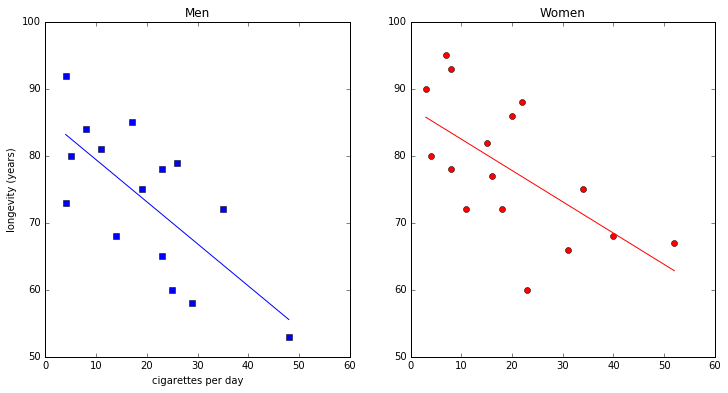

In [12]:
fig = plt.figure(1, figsize=(12, 6))
ax1 = plt.subplot2grid((1,2), (0,0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1,2), (0,1), rowspan=1, colspan=1, sharey=ax1)

ax1.set_title('Men')
ax2.set_title('Women')

ax1.set_xlim(0, 60); ax2.set_xlim(0, 60)
ax1.set_ylim(50, 100); ax2.set_ylim(50, 100)
ax1.set_ylabel('longevity (years)')
ax1.set_xlabel('cigarettes per day')

ax1.plot(men_data['cig_x'], men_data['life_exp'], 'bs')
ax1.plot(X_men, T_men, 'b')
ax2.plot(women_data['cig_x'], women_data['life_exp'], 'ro')
ax2.plot(X_women, T_women, 'r')

Slopes look different enough to suggest that increased smoking decreases longevity fast in men than women (blue slope steeper than red slope), but we need to do the proper statistical test on these values to see if this is really true or not.  The null hypothesis would be $H_0 : w^{men}_{1} = w^{women}_{1}$

Start by computing the slopes: $w^{men}_{1}$ and $w^{women}_{1}$

In [13]:
n_men = men_data.shape[0]
n_women = women_data.shape[0]
# get the slopes, start by getting x and targets for each class (men, women)
x_men = np.array(men_data['cig_x'])[:, np.newaxis]
t_men = np.array(men_data['life_exp'])[:, np.newaxis]
x_women = np.array(women_data['cig_x'])[:, np.newaxis]
t_women = np.array(women_data['life_exp'])[:, np.newaxis]
# row 5 of http://i1.wp.com/www.real-statistics.com/wp-content/uploads/2012/12/Comparing-regression-line-slopes.png
slope_men = trainLinear(x_men, t_men)[1]        # should be -0.6282
slope_women = trainLinear(x_women, t_women)[1]  # should be -0.4679
slope_men, slope_women

(array([-0.62820041]), array([-0.46785962]))

Next, we need to calculate the t-statistic which is:  
\begin{align*}
t = \frac{w_{1, men} - w_{1, women}}{\sqrt{s_{w_{1, men}}^2 + s_{w_{1, women}}^2}}
\end{align*}

We have computed the terms of the numerator, so we need to compute the denominator which is the standard error of difference in the slopes.  Doing this requires that we first calculate the variances of each of the regression slopes.  This variance is defined [here](http://www.real-statistics.com/regression/hypothesis-testing-significance-regression-line-slope/) as:  $s_{b}^2 = \frac{s_{yx}^2}{s_{x}^2(n-1)} = s_{w_{1}}^2$ where the numerator is defined as $s_{yx} = s_y \sqrt{(1-r^2)\frac{n-1}{n-2}}$ where $r^2$ is the *coefficient of determination* between $x$ and $y$.

In [14]:
# row 7 of http://i1.wp.com/www.real-statistics.com/wp-content/uploads/2012/12/Comparing-regression-line-slopes.png
s_x_men = np.std(x_men, ddof=1); s_x_women = np.std(x_women, ddof=1)
s_x_men, s_x_women

(12.45448857698644, 13.851594372730768)

Now compute $r^2$ for each genders regression:

In [15]:
r2_men = np.corrcoef(x_men.T, t_men.T)[1][0]**2 # r=-0.71343 as shown in example, r^2=0.5090
r2_women = np.corrcoef(x_women.T, t_women.T)[1][0]**2
r2_men, r2_women

(0.50898261372526732, 0.39057495080349064)

Compute the standard deviations of each genders targets ($s_{y, men}$ and $s_{y, women}$):

In [16]:
# std. dev. of the targets (longevity) for men and women
s_y_men = np.std(t_men, ddof=1); s_y_women = np.std(t_women, ddof=1)
s_y_men, s_y_women  # s_y_men=10.96662

(10.966616007988366, 10.369627122836514)

Compute $s_{yx}$ for each genders regression using $s_{yx} = s_y \sqrt{(1-r^2)\frac{n-1}{n-2}}$:

In [17]:
syx_men = s_y_men * np.sqrt((1-r2_men)*(n_men-1)/(n_men-2))  # 7.97468
syx_women = s_y_women * np.sqrt((1-r2_women)*(n_women-1)/(n_women-2))
syx_men, syx_women

(7.9746827306891683, 8.3792452578993188)

In [18]:
sb_men = syx_men / (s_x_men * np.sqrt(n_men-1))
sb_women = syx_women / (s_x_women * np.sqrt(n_women-1))
sb_men, sb_women  # 0.171129, 0.156192

(0.17112895461639729, 0.15619225948227389)

We now have everything we need to calculate the t-statistic which is again:  
\begin{align*}
t = \frac{w_{1, men} - w_{1, women}}{\sqrt{s_{w_{1, men}}^2 + s_{w_{1, women}}^2}}
\end{align*}

In [19]:
sdev_slope_diff = np.sqrt(sb_men**2 + sb_women**2)
sdev_slope_diff  # 0.231692

0.23169190972124801

In [22]:
t_stat = (slope_men[0] - slope_women[0]) / sdev_slope_diff
df = n_men + n_women - 4
t_stat, df

(-0.69204306997484732, 27)

In [23]:
import scipy.stats as ss
